<a href="https://colab.research.google.com/github/AmineHamzaoui/Financial-Market-Forcesating/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Without Macro variables etc..

#With Macro variables

Colonnes disponibles : Index(['Unnamed: 0', 'Date_x', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'Stock', 'Daily_Return', 'Price_Range',
       'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change', 'DateOnly_x',
       'Month', 'Date_y', 'Interest Rate (Federal Funds)', 'Unemployment Rate',
       'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)',
       'Inflation (PCE Index)', 'DateOnly_y', 'Stock_encoded'],
      dtype='object')
Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 1.3991 - mae: 0.3452 - val_loss: 0.1891 - val_mae: 0.2761
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.3083 - mae: 0.3753 - val_loss: 0.1391 - val_mae: 0.2780
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.0115 - mae: 0.3532 - val_loss: 0.0530 - val_mae: 0.0510
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.3100 - mae: 0.1390 - val_loss: 0.0628 - val_mae: 0.0745
Epoch 5/500
145/145 ━━━━━━━━━

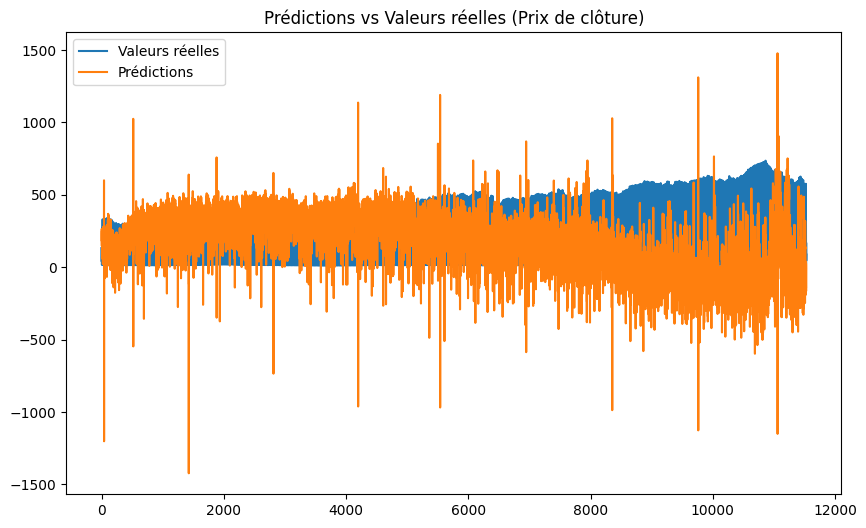

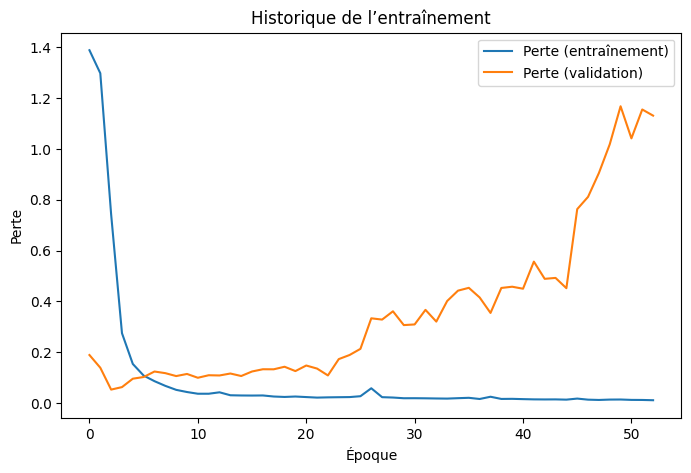

In [ ]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv('/content/Macro_with_stocks.csv', sep=',')

# Inspecter les colonnes
print("Colonnes disponibles :", df.columns)

# Convertir la colonne de date
date_column = 'Date_x'
df['Date'] = pd.to_datetime(df[date_column], utc=True)
df = df.dropna(subset=['Close'])  # Supprimer les lignes avec Close manquant

# Définir les caractéristiques et la cible
features = [
    'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
    'Daily_Return', 'Price_Range', 'Volatility', 'Close_Lag1',
    'Open_Lag1', 'Volume_Change', 'Interest Rate (Federal Funds)',
    'Unemployment Rate', 'Consumer Price Index (CPI)',
    'GDP Growth (Real GDP % Change)', 'Inflation (PCE Index)'
]
target = ['Close']

# Vérifier les colonnes manquantes
missing_cols = [col for col in features + target if col not in df.columns]
if missing_cols:
    print(f"Colonnes manquantes : {missing_cols}")
    features = [col for col in features if col in df.columns]

# Nettoyage des données
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=features)

# Diviser les données : 80% entraînement, 20% test
split_ind = int(len(df) * 0.8)
df_tr = df.iloc[:split_ind]
df_ts = df.iloc[split_ind:]

# Créer des séquences temporelles
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_tr, y_tr = create_sequences(df_tr[features].values, df_tr[target].values, time_steps)
X_ts, y_ts = create_sequences(df_ts[features].values, df_ts[target].values, time_steps)

# Vérification pour éviter les erreurs
if X_tr.shape[0] == 0 or X_ts.shape[0] == 0:
    raise ValueError("Aucune séquence générée. Vérifiez la taille des données ou réduisez le time_steps.")

# Normaliser les données
scaler_X = StandardScaler()
X_tr = scaler_X.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_ts = scaler_X.transform(X_ts.reshape(-1, X_ts.shape[-1])).reshape(X_ts.shape)

scaler_y = StandardScaler()
y_tr = scaler_y.fit_transform(y_tr)
y_ts = scaler_y.transform(y_ts)

# Créer le modèle LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(time_steps, len(features))),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, recurrent_activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(1)
])

# Compiler le modèle
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(X_tr, y_tr, validation_split=0.2, epochs=500, batch_size=256,
                    callbacks=[early_stopping], verbose=1)

# Évaluer le modèle
y_pred = model.predict(X_ts)
y_pred = scaler_y.inverse_transform(y_pred)
y_ts = scaler_y.inverse_transform(y_ts)

mse = mean_squared_error(y_ts, y_pred)
mae = mean_absolute_error(y_ts, y_pred)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')

# Visualiser les prédictions
plt.figure(figsize=(10, 6))
plt.plot(y_ts, label='Valeurs réelles')
plt.plot(y_pred, label='Prédictions')
plt.title('Prédictions vs Valeurs réelles (Prix de clôture)')
plt.legend()
plt.show()

# Visualiser l'historique
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Historique de l’entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()


Colonnes disponibles : Index(['Unnamed: 0', 'Date_x', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'Stock', 'Daily_Return', 'Price_Range',
       'Volatility', 'Close_Lag1', 'Open_Lag1', 'Volume_Change', 'DateOnly_x',
       'Month', 'Date_y', 'Interest Rate (Federal Funds)', 'Unemployment Rate',
       'Consumer Price Index (CPI)', 'GDP Growth (Real GDP % Change)',
       'Inflation (PCE Index)', 'DateOnly_y', 'Stock_encoded'],
      dtype='object')
Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 1.3770 - mae: 0.3438 - val_loss: 0.1873 - val_mae: 0.2675
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 1.3150 - mae: 0.3732 - val_loss: 0.1409 - val_mae: 0.2641
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 1.3032 - mae: 0.3768 - val_loss: 0.1055 - val_mae: 0.2501
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.2098 - mae: 0.3800 - val_loss: 0.5329 - val_mae: 0.3316
Epoch 5/500
145/145 ━━━━━━━━━━

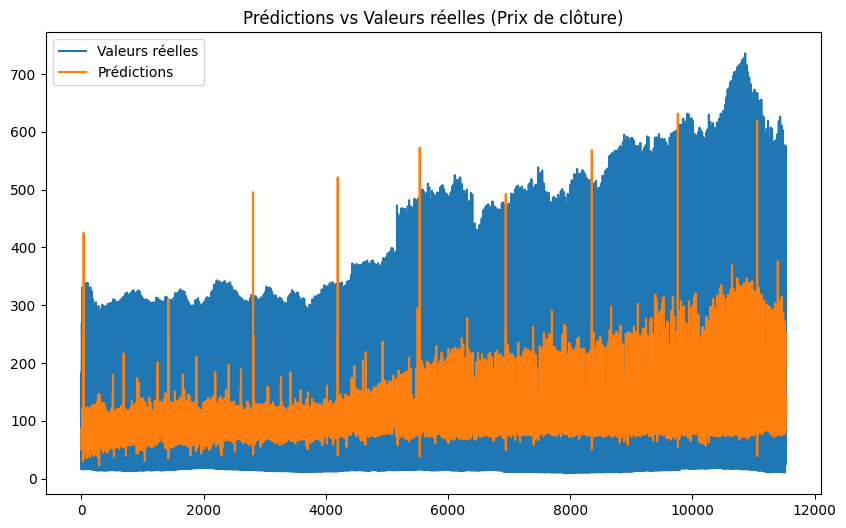

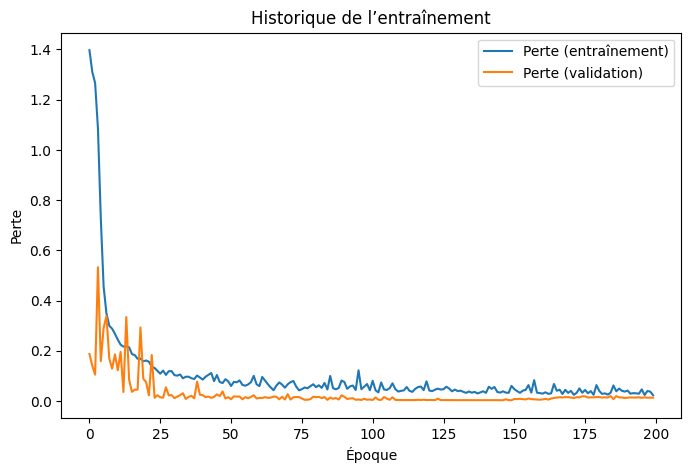

In [ ]:
# Importer les bibliothèques
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv('/content/Macro_with_stocks.csv', sep=',')

# Inspecter les colonnes
print("Colonnes disponibles :", df.columns)

# Convertir la colonne de date
date_column = 'Date_x'
df['Date'] = pd.to_datetime(df[date_column], utc=True)
df = df.dropna(subset=['Close'])  # Supprimer les lignes avec Close manquant

# Définir les caractéristiques et la cible
features = [
    'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',

]
target = ['Close']

# Vérifier les colonnes manquantes
missing_cols = [col for col in features + target if col not in df.columns]
if missing_cols:
    print(f"Colonnes manquantes : {missing_cols}")
    features = [col for col in features if col in df.columns]

# Nettoyage des données
df[features] = df[features].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=features)

# Diviser les données : 80% entraînement, 20% test
split_ind = int(len(df) * 0.8)
df_tr = df.iloc[:split_ind]
df_ts = df.iloc[split_ind:]

# Créer des séquences temporelles
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_tr, y_tr = create_sequences(df_tr[features].values, df_tr[target].values, time_steps)
X_ts, y_ts = create_sequences(df_ts[features].values, df_ts[target].values, time_steps)

# Vérification pour éviter les erreurs
if X_tr.shape[0] == 0 or X_ts.shape[0] == 0:
    raise ValueError("Aucune séquence générée. Vérifiez la taille des données ou réduisez le time_steps.")

# Normaliser les données
scaler_X = StandardScaler()
X_tr = scaler_X.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_ts = scaler_X.transform(X_ts.reshape(-1, X_ts.shape[-1])).reshape(X_ts.shape)

scaler_y = StandardScaler()
y_tr = scaler_y.fit_transform(y_tr)
y_ts = scaler_y.transform(y_ts)

# Créer le modèle LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(time_steps, len(features))),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, recurrent_activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(1)
])

# Compiler le modèle
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(X_tr, y_tr, validation_split=0.2, epochs=500, batch_size=256,
                    callbacks=[early_stopping], verbose=1)

# Évaluer le modèle
y_pred = model.predict(X_ts)
y_pred = scaler_y.inverse_transform(y_pred)
y_ts = scaler_y.inverse_transform(y_ts)

mse = mean_squared_error(y_ts, y_pred)
mae = mean_absolute_error(y_ts, y_pred)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')

# Visualiser les prédictions
plt.figure(figsize=(10, 6))
plt.plot(y_ts, label='Valeurs réelles')
plt.plot(y_pred, label='Prédictions')
plt.title('Prédictions vs Valeurs réelles (Prix de clôture)')
plt.legend()
plt.show()

# Visualiser l'historique
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Historique de l’entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()


In [ ]:
df

,Unnamed: 0,Date_x,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock,...,Month,Date_y,Interest Rate (Federal Funds),Unemployment Rate,Consumer Price Index (CPI),GDP Growth (Real GDP % Change),Inflation (PCE Index),DateOnly_y,Stock_encoded,Date
0,1,2015-01-05 00:00:00-05:00,37.053267,37.181924,36.483501,36.575397,2041800,0.0,0.0,A,...,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01,0,2015-01-05 05:00:00+00:00
1,2604,2015-01-05 00:00:00-05:00,51.515765,51.676843,50.539838,51.051491,11565000,0.0,0.0,AAL,...,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01,1,2015-01-05 05:00:00+00:00
2,5207,2015-01-05 00:00:00-05:00,24.089084,24.169166,23.448429,23.635286,257142000,0.0,0.0,AAPL,...,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01,2,2015-01-05 05:00:00+00:00
3,10413,2015-01-05 00:00:00-05:00,78.554785,78.554785,77.191422,77.412086,2124700,0.0,0.0,AMT,...,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01,4,2015-01-05 05:00:00+00:00
4,13016,2015-01-05 00:00:00-05:00,15.350500,15.419000,15.042500,15.109500,55484000,0.0,0.0,AMZN,...,2015-01-01,2015-01-01,0.11,5.7,234.747,3.6,96.654,2015-01-01,5,2015-01-05 05:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57700,48458,2025-03-31 00:00:00-04:00,48.500000,48.590000,47.119999,48.279999,12190200,0.0,0.0,NEM,...,2025-03-01,2025-03-01,4.33,4.2,319.615,-0.3,125.732,2025-03-01,18,2025-03-31 04:00:00+00:00
57701,51061,2025-03-31 00:00:00-04:00,24.335741,24.953948,24.149299,24.865633,53498100,0.0,0.0,PFE,...,2025-03-01,2025-03-01,4.33,4.2,319.615,-0.3,125.732,2025-03-01,19,2025-03-31 04:00:00+00:00
57702,53664,2025-03-31 00:00:00-04:00,167.058668,170.079829,167.058668,169.364288,11520100,0.0,0.0,PG,...,2025-03-01,2025-03-01,4.33,4.2,319.615,-0.3,125.732,2025-03-01,20,2025-03-31 04:00:00+00:00
57703,56267,2025-03-31 00:00:00-04:00,44.360634,44.944454,44.360634,44.697071,1932500,0.0,0.0,UDR,...,2025-03-01,2025-03-01,4.33,4.2,319.615,-0.3,125.732,2025-03-01,21,2025-03-31 04:00:00+00:00
